In [ ]:
!pip install opendatasets
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/mehradaria/leukemia'

od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nurealamnadim
Your Kaggle Key: ··········


100%|██████████| 110M/110M [00:00<00:00, 234MB/s] 


In [ ]:
!pip install Keras
!pip install vit-keras
!pip install tensorflow-addons
!pip install opendatasets
import opendatasets as od
import pandas

import os

import keras.preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import layers
from keras import regularizers, activations
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50V2
from keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!pip install patool  ## unzip rar files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
import os
from patoolib import extract_archive

def unzip_rar_files(folder_path):
    # Get a list of all files in the specified folder
    files = os.listdir(folder_path)

    # Iterate through each file in the folder
    for file in files:
        file_path = os.path.join(folder_path, file)

        # Check if the file is a .rar file
        if file.endswith(".rar"):
            try:
                # Extract the .rar file using patoolib
                extract_archive(file_path, outdir=folder_path)
                print(f"Successfully extracted: {file}")
            except Exception as e:
                print(f"Error extracting {file}: {e}")

# Specify the folder path containing the .rar files
folder_path = "/content/leukemia/Original"

# Call the function to unzip .rar files in the specified folder
unzip_rar_files(folder_path)

In [ ]:
base_dir = '/content/leukemia/Original'

In [ ]:
import os

def get_folder_names(directory_path):
    # Initialize an empty list to store folder names
    folder_names = []

    # Iterate over items in the specified directory
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        # Check if the item is a directory
        if os.path.isdir(item_path):
          if item != '.ipynb_checkpoints':
            folder_names.append(item)

    return folder_names

# Specify the directory path for which you want to fetch folder names
directory_path = "/content/leukemia/Original"

# Call the function to get folder names in the specified directory
folders = get_folder_names(directory_path)

# Print the list of folder names
print("Folder Names:", folders)


Folder Names: ['Benign', 'Pre', 'Early', 'Pro']


In [ ]:
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [ ]:
import shutil

# List of class folder names
class_folders = folders
# Split ratios (adjust these as needed)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for folder in class_folders:
    source_folder = os.path.join(base_dir, folder)
    train_dest=os.path.join(train_dir, folder)
    val_dest = os.path.join(val_dir, folder)
    test_dest = os.path.join(test_dir, folder)

    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    filenames = os.listdir(source_folder)
    num_files = len(filenames)

    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)

    train_files = filenames[:num_train]
    val_files = filenames[num_train:num_train + num_val]
    test_files = filenames[num_train + num_val:]

    for file in train_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(train_dest, file)
        shutil.copy(src_path, dest_path)

    for file in val_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(val_dest, file)
        shutil.copy(src_path, dest_path)

    for file in test_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(test_dest, file)
        shutil.copy(src_path, dest_path)



In [ ]:
size = 224

batch_size = 64
target_size = (size,size)  # Adjust as needed

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

Found 2277 images belonging to 4 classes.
Found 486 images belonging to 4 classes.
Found 493 images belonging to 4 classes.


In [ ]:
test_labels = np.array(test_generator.labels)


Epoch 1/25
35/35 [==============================] - 57s 1s/step - loss: 1.3026 - accuracy: 0.3425 - val_loss: 0.9234 - val_accuracy: 0.6406
Epoch 2/25
35/35 [==============================] - 30s 860ms/step - loss: 0.9660 - accuracy: 0.6213 - val_loss: 0.6156 - val_accuracy: 0.7522
Epoch 3/25
35/35 [==============================] - 33s 933ms/step - loss: 0.5886 - accuracy: 0.7601 - val_loss: 0.5350 - val_accuracy: 0.7612
Epoch 4/25
35/35 [==============================] - 32s 904ms/step - loss: 0.5378 - accuracy: 0.7682 - val_loss: 0.5187 - val_accuracy: 0.7902
Epoch 5/25
35/35 [==============================] - 31s 879ms/step - loss: 0.4794 - accuracy: 0.7858 - val_loss: 0.4568 - val_accuracy: 0.7924
Epoch 6/25
35/35 [==============================] - 31s 879ms/step - loss: 0.4784 - accuracy: 0.7953 - val_loss: 0.4234 - val_accuracy: 0.8214
Epoch 7/25
35/35 [==============================] - 31s 882ms/step - loss: 0.4469 - accuracy: 0.8256 - val_loss: 0.3858 - val_accuracy: 0.8304
Ep

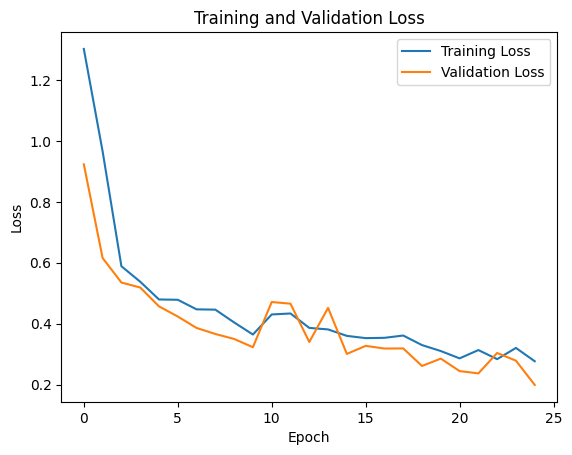

8/8 [==============================] - 2s 316ms/step - loss: 0.2026 - accuracy: 0.9229
Test Loss: 0.20259322226047516
Test Accuracy: 0.9229208827018738
8/8 [==============================] - 1s 131ms/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(size, size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_folders), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=25,  # 20 epochs as requested
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size)

# Print validation accuracy and loss
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Get predictions on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_classes = test_generator.classes

## Plot confusion matrix
#conf_matrix = confusion_matrix(true_classes, y_pred_classes)
#plt.figure(figsize=(8, 6))
#plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
#plt.colorbar()
#tick_marks = np.arange(len(class_folders))
#pplt.title('Confusion Matrix')
#lt.xticks(tick_marks, class_folders, rotation=45)
#plt.yticks(tick_marks, class_folders)
#plt.xlabel('Predicted Class')
#plt.ylabel('True Class')
#plt.show()##

8/8 [==============================] - 2s 214ms/step


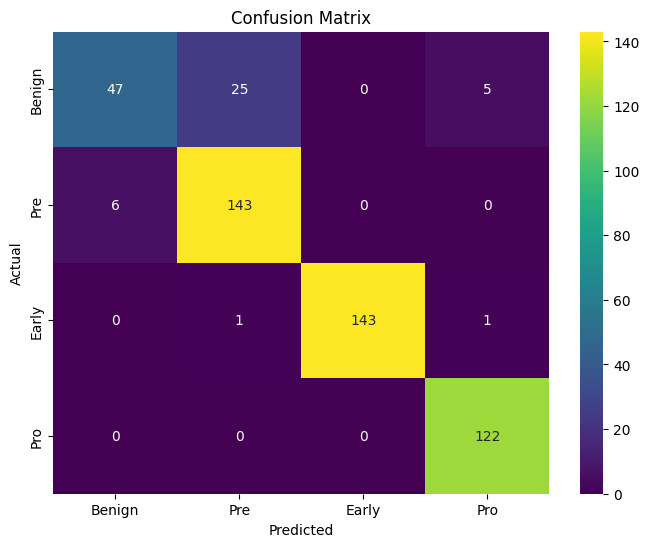

Precision: 0.8511904761904762
Recall: 0.959731543624161
F1 Score: 0.9022082018927444


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and compiled your model
# train_ds is your training dataset

# Make predictions using the trained model
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels(Vartically data genaranor)
predicted_labels = np.argmax(predictions, axis=1)

# Get the actual labels from the dataset

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
classes = class_folders


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already trained and compiled your model
# train_ds is your training dataset
classes = class_folders

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='viridis',
            xticklabels=classes, yticklabels=classes)  # Replace 'classes' with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

cm= confusion_mtx
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]


# Calculate metrics
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

8/8 [==============================] - 2s 213ms/step


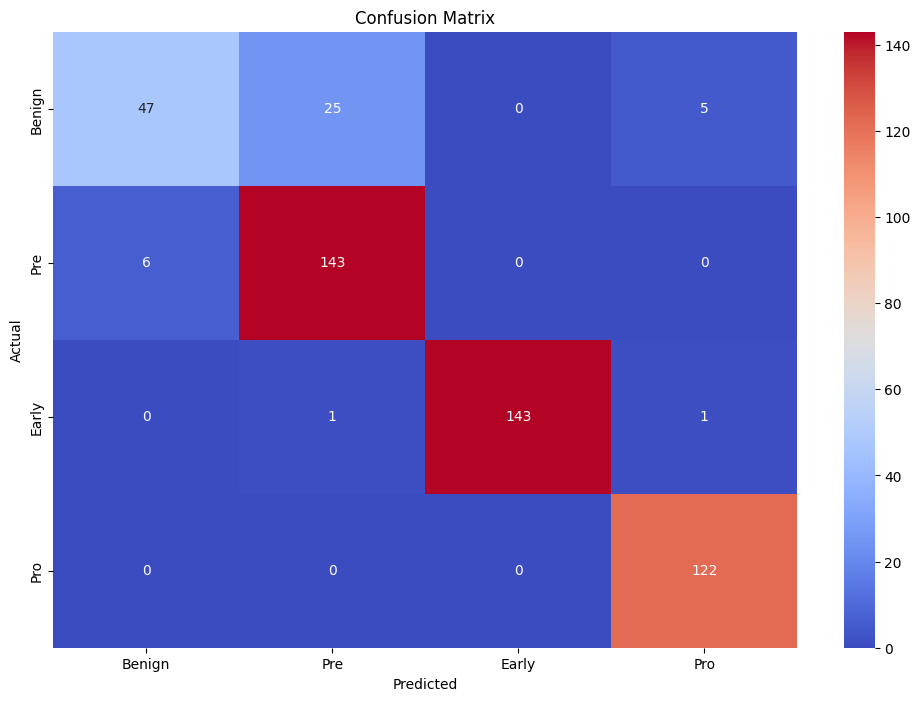

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and compiled your model
# train_ds is your training dataset

# Make predictions using the trained model
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the actual labels from the dataset

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
classes = class_folders


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

classes = class_folders

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=classes, yticklabels=classes)  # Replace 'classes' with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



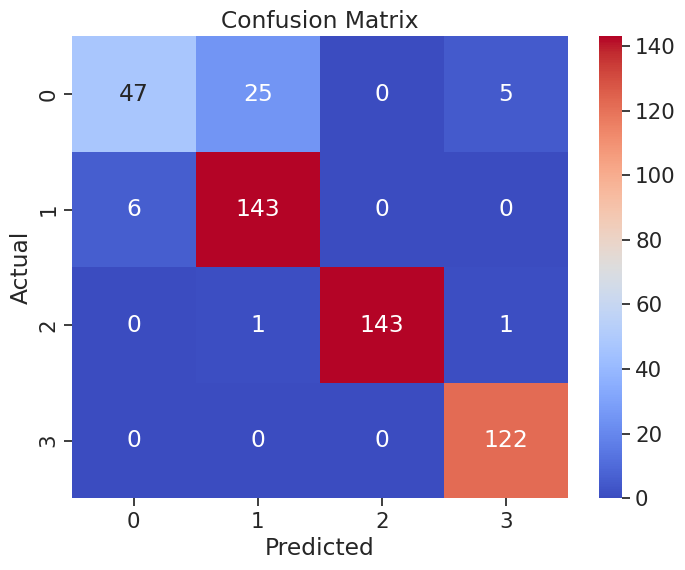

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already trained and compiled your model
# train_ds is your training dataset
classes = [0,1,2,3]
# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Set the font scale
sns.set_style("ticks", {"font.family": "Times New Roman"})  # Set the font family to Times New Roman
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=classes, yticklabels=classes)  # Replace 'classes' with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


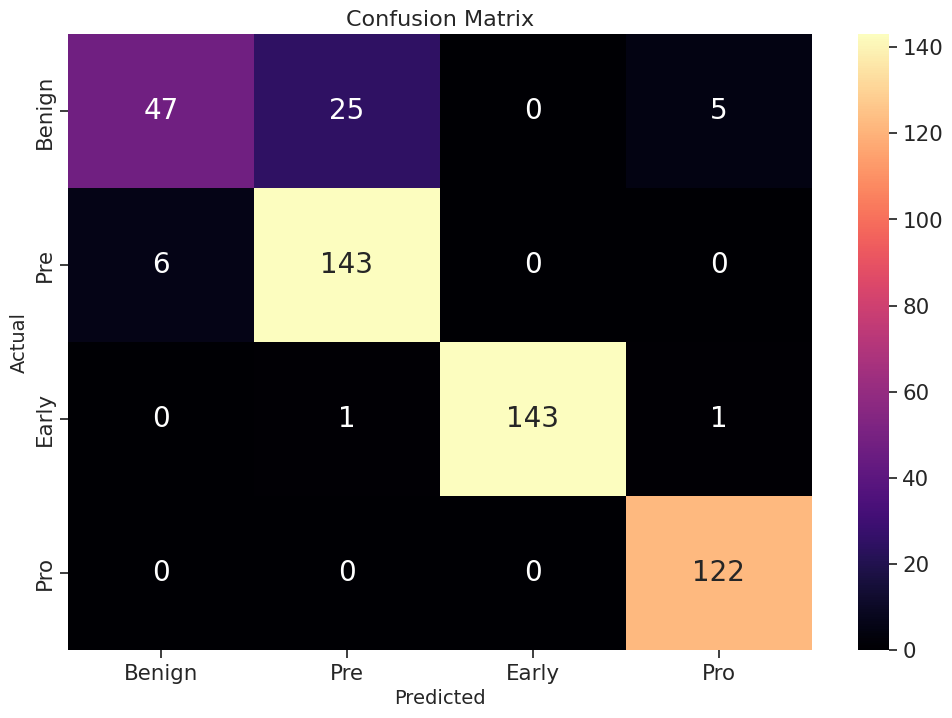

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

classes = class_folders

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='magma',
            xticklabels=classes, yticklabels=classes, annot_kws={"fontsize": 20})  # Adjust fontsize as needed
plt.xlabel('Predicted', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Actual', fontsize=14)  # Adjust fontsize as needed
plt.title('Confusion Matrix', fontsize=16)  # Adjust fontsize as needed
plt.savefig('images.pdf')
plt.show()


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# prompt: print the precision recall and f1 score

from sklearn.metrics import classification_report
# Get the classification report
report = classification_report(test_labels, predicted_labels)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.89      0.61      0.72        77
           1       0.85      0.96      0.90       149
           2       1.00      0.99      0.99       145
           3       0.95      1.00      0.98       122

    accuracy                           0.92       493
   macro avg       0.92      0.89      0.90       493
weighted avg       0.92      0.92      0.92       493



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming test_labels and predicted_labels are your actual and predicted labels
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9242214846751473
Recall: 0.922920892494929
F1 Score: 0.9183534846666425


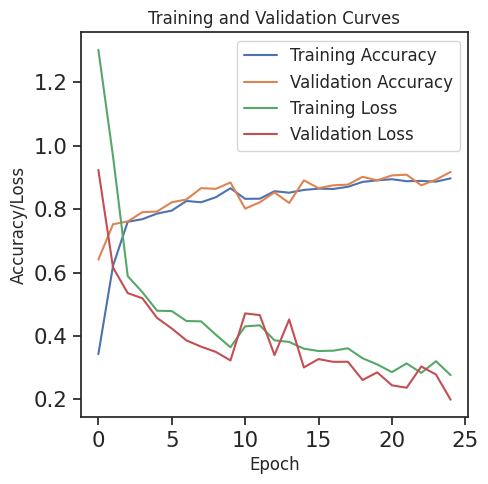

In [ ]:
# prompt: plot the trainig and validation curves using seaborn

import matplotlib.pyplot as plt
# Plot training and validation curves using Seaborn
import seaborn as sns

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot training and validation accuracy
sns.lineplot(x=history.epoch, y=acc, label='Training Accuracy', ax=ax)
sns.lineplot(x=history.epoch, y=val_acc, label='Validation Accuracy', ax=ax)

# Plot training and validation loss
sns.lineplot(x=history.epoch, y=loss, label='Training Loss', ax=ax)
sns.lineplot(x=history.epoch, y=val_loss, label='Validation Loss', ax=ax)

# Set labels and title
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy/Loss', fontsize=12)
ax.set_title('Training and Validation Curves', fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


<Figure size 640x480 with 0 Axes>

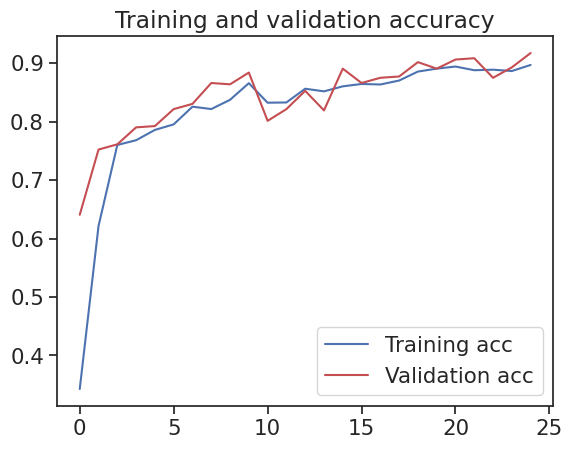

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

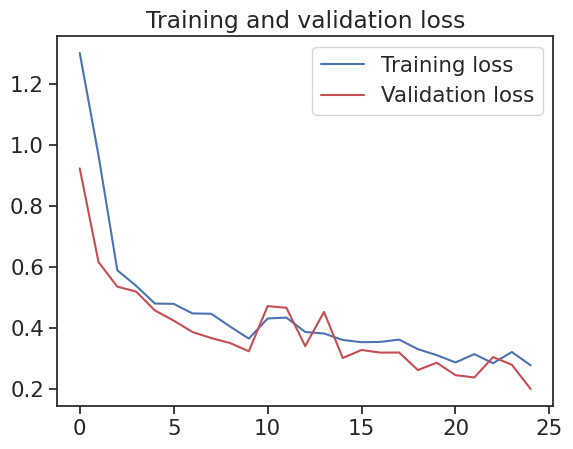

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# prompt: print the classification report

print(classification_report(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), target_names=classes))


8/8 [==============================] - 2s 184ms/step
              precision    recall  f1-score   support

      Benign       0.89      0.61      0.72        77
         Pre       0.85      0.96      0.90       149
       Early       1.00      0.99      0.99       145
         Pro       0.95      1.00      0.98       122

    accuracy                           0.92       493
   macro avg       0.92      0.89      0.90       493
weighted avg       0.92      0.92      0.92       493



In [ ]:
# prompt: print the precision, recall and f1 score

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already evaluated your model and have the following variables:
# test_generator.classes: True labels
# model.predict(test_generator): Predicted probabilities
# classes: List of class names

# Calculate precision, recall, and F1-score for each class
precision = precision_score(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), average=None, labels=range(len(classes)))
recall = recall_score(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), average=None, labels=range(len(classes)))
f1 = f1_score(test_generator.classes, np.argmax(model.predict(test_generator), axis=1), average=None, labels=range(len(classes)))

# Print the results
for i, cls in enumerate(classes):
    print(f"Class {cls}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print()


8/8 [==============================] - 2s 203ms/step
Class Benign:
Precision: 0.8868
Recall: 0.6104
F1-score: 0.7231

Class Pre:
Precision: 0.8462
Recall: 0.9597
F1-score: 0.8994

Class Early:
Precision: 1.0000
Recall: 0.9862
F1-score: 0.9931

Class Pro:
Precision: 0.9531
Recall: 1.0000
F1-score: 0.9760



8/8 [==============================] - 2s 241ms/step


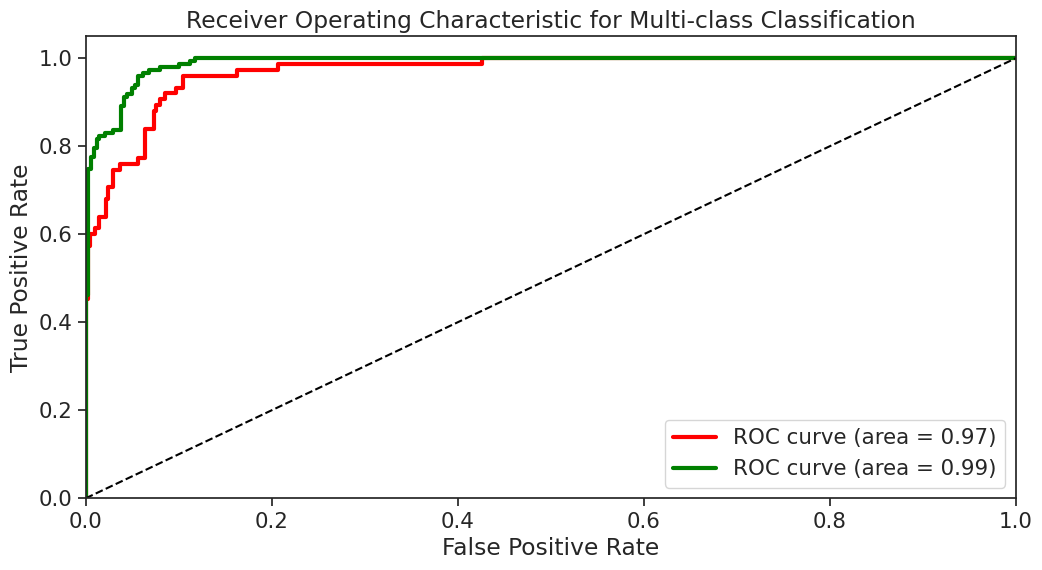

AUC scores:
Class 1: 0.970089213300892
Class 2: 0.9890434049726085


In [ ]:
# prompt: ROC Curve display for deep learning

# Get predicted probabilities for each class
predictions = model.predict(val_generator)

# Get the actual labels
test_labels = np.array(val_generator.labels)

# Binarize the test labels
test_labels_bin = keras.utils.to_categorical(test_labels)

# Calculate ROC curves and AUC for each class
fpr = {}
tpr = {}
auc_scores = {}

n_classes = 2  # Adjust this to your number of classes

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predictions[:, i])
    auc_scores[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(12, 6))


lw = 3
colors = ['red', 'green', 'blue', 'orange']  # Adjust colors for each class

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f)' % auc_scores[i])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

# Print AUC scores
print('AUC scores:')
for i, score in auc_scores.items():
    print(f'Class {i+1}: {score}')


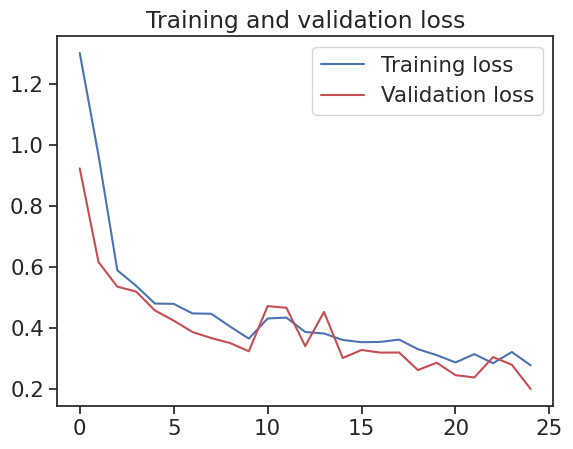

In [ ]:

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<Figure size 640x480 with 0 Axes>

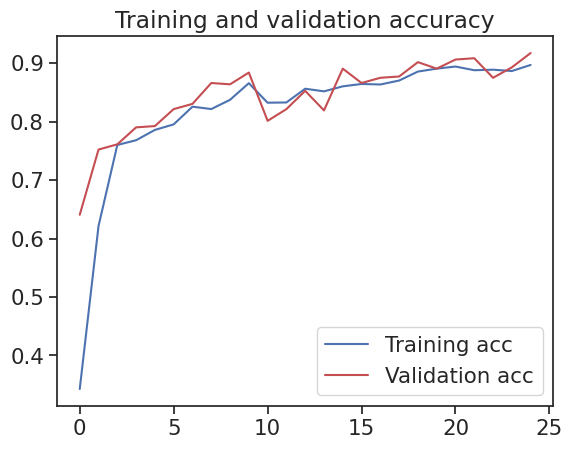

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

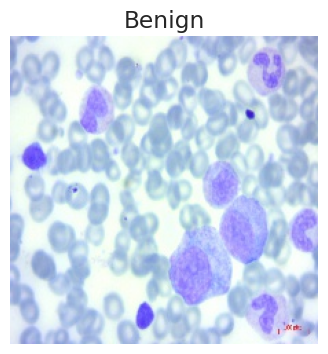

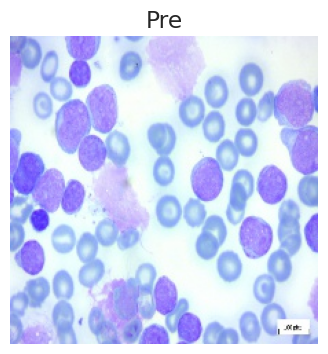

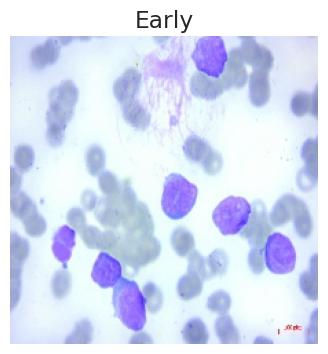

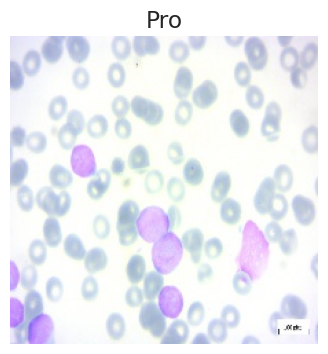

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Function to plot one image from a folder with folder name as label
def plot_image_with_label(folder_path):
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]

    # Check if there's at least one image in the folder
    if image_files:
        # Read the first image in the folder
        image_path = os.path.join(folder_path, image_files[0])
        image = Image.open(image_path)

        # Plot the image
        plt.figure(figsize=(6, 4))
        sns.set_style("whitegrid")
        plt.imshow(image)
        plt.title(os.path.basename(folder_path))  # Use folder name as title
        plt.axis('off')
        plt.show()

# Main folder containing subfolders with images
main_folder = '/content/leukemia/Original'

# Get the list of subfolders in the main folder
subfolders = [os.path.join(main_folder, d) for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]

# Plot one image from each subfolder with folder name as label
for subfolder in subfolders:
    plot_image_with_label(subfolder)


In [ ]:
# prompt: show the model architecture

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

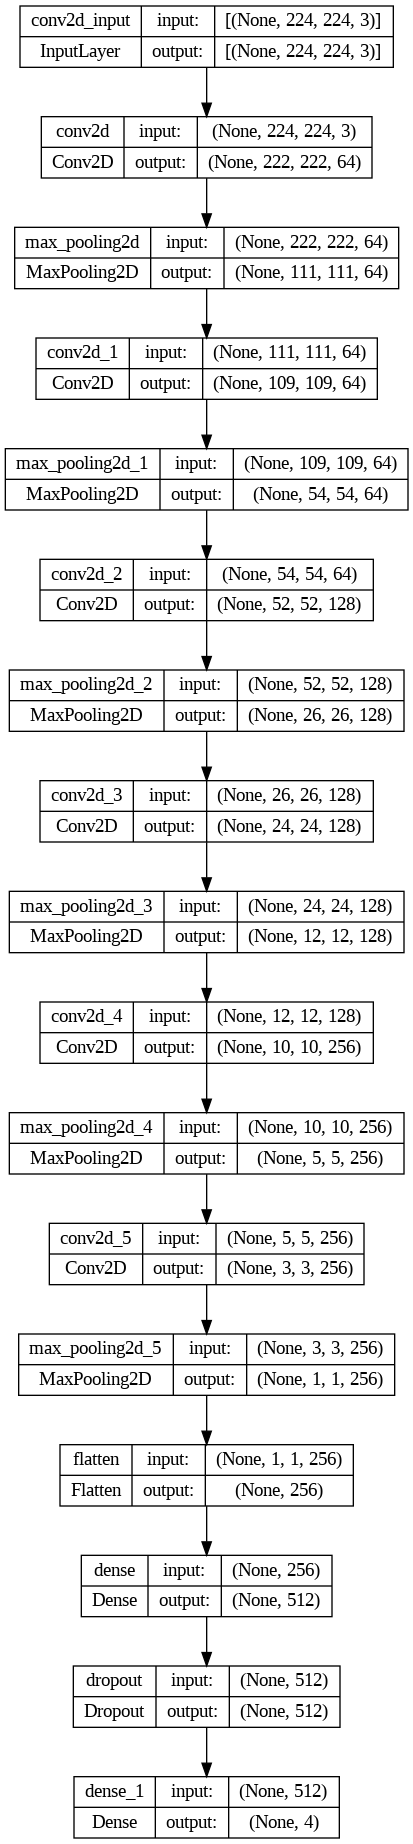

In [ ]:
# Visualize the model architecture
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.save("leukemia.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
